In [8]:
import pandas as pd
from sklearn import linear_model
import os
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn import metrics
import itertools
from sklearn.metrics import confusion_matrix
import pickle

In [9]:
def plotAUC(truth, pred, lab, stdErrData):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # stdErrData.append(tpr.tolist())
    # nparrayPlot = np.array(stdErrData)
    # stdabweichung = nparrayPlot.std(axis=0)
    
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    
    
    # plt.errorbar(fpr, tpr, yerr=stdabweichung, fmt='_')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")
    
    
    
def plot_confusion_matrix(y_test, model, label='', normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Funded", "Not Funded"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix: " + label
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def mappeDaten(dataset): 

    # Baue Datensatz auf
    data_with_funding_limit_sliced = dataset[(dataset['d_fundlim'] ==1) | (dataset['d_fundlim']==0)]
    
    # Dummy-Conversion
    di = {0:0, 1:1}   #converting target variable to boolean
    
    # Boolsches Ergebnis
    Dataset_withBoolTarget= data_with_funding_limit_sliced.replace({'d_fundlim': di})
    
    Dataset_withBoolTarget['d_fundlim'].value_counts()
    print("Current shape of dataset :",Dataset_withBoolTarget.shape)
    Dataset_withBoolTarget.head(3)
    
    
    # Loesche unnoetige Leerzeilen
    dataset=Dataset_withBoolTarget.dropna(thresh = 1,axis=1) #340000 is minimum number of non-NA values
    print("Current shape of dataset :",dataset.shape)
    
    
    # Waehle die Daten aus
    features = ['d_fundlim', 'p_selfemplexp', 'p_startupexp', 'p_foundhist', 'p_ttempl', 'p_leadexp', 'p_femfounder',
    'p_vocedu', 'p_bachelor', 'p_master', 'p_mba', 'p_phd', 'p_ttuni',
    'd_Patents_registered', 'd_Trademark', 'd_govgrant', 'd_awards',
    'n_network', 'd_expert', 'd_angel', 'd_academic',
    'n_picgraph', 'n_words', 'n_vidlength',
    'd_reward', 'plat', 'year_fund', 'location','bstage', 'conttype', 'equityoffer', 'comptype']
    
    
    Final_data = dataset[features] #19 features with target var
    #Final_data= Final_data.reset_index(drop=True)
    print("Current shape of dataset :",Final_data.shape)
    
    # Fuehre ein Mapping auf Integer-Werte durch
    Final_data['comptype'] = Final_data['comptype'].map({'GmbH':0,'UG':1})
    Final_data['location'] = Final_data['location'].map({'Muenchen':0,'Berlin':1,'Hamburg':2,'Other':3})
    Final_data['conttype'] = Final_data['conttype'].map({'shareholder subordinated loan':0,'silent partnership':1, 'shareholder loan ':2})
    Final_data['bstage'] = Final_data['bstage'].map({'start-up':0,'seed':1,'growth':2})
    Final_data['plat'] = Final_data['plat'].map({'seedmatch':0,'innovestment':1,'companisto':2})
    Final_data['year_fund'] = Final_data['year_fund'].map({2011:0,2012:1,2013:2,2014:3,2015:4})
    
    print("Current shape of dataset :",Final_data.shape)
    Final_data.head()
    
    # Fill missing feature (nothing there)
    Final_data.fillna(Final_data.mean(),inplace = True)
    HTML(Final_data.tail().to_html())
    print("Current shape of dataset :",Final_data.shape)
    
    # Clean data 
    scl = preprocessing.StandardScaler() #instance of preprocessing
    fields = Final_data.columns.values[1:]
    
    # Alle Spalten auf Gasu Verteilung gemappt
    data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
    
    # Binär Variablen werden wieder auf eins und null gesetzt
    data_clean['d_Patents_registered'] = Final_data['d_Patents_registered']
    data_clean['d_Trademark'] = Final_data['d_Trademark']
    data_clean['d_govgrant'] = Final_data['d_govgrant']
    data_clean['d_awards'] = Final_data['d_awards']
    data_clean['d_expert'] = Final_data['d_expert']
    data_clean['d_angel'] = Final_data['d_angel']
    data_clean['d_academic'] = Final_data['d_academic']
    data_clean['d_reward'] = Final_data['d_reward']
    data_clean['comptype'] = Final_data['comptype']
    data_clean['d_fundlim'] = Final_data['d_fundlim']
    data_clean['d_fundlim'].value_counts()
    
    
    #data_clean = data_clean.sample(frac=1).reset_index(drop=True)
    print("Current shape of dataset :",data_clean.shape)
    data_clean.head()
    data_clean.corr()
    
    return data_clean

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(0.00001, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

def loadData():
    dataset1 = pd.read_excel('Basisdaten_20210721.xlsx')
    return dataset1

def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")


In [10]:
os.chdir(r"/home/mark/my_project/venv")
dataset1 = loadData()
# Mappe Daten auf Gauss-Verteilung und ordne kategorische Variablen einem Integer-Wert zu
data_clean = mappeDaten(dataset1)

Current shape of dataset : (163, 121)
Current shape of dataset : (163, 114)
Current shape of dataset : (163, 32)
Current shape of dataset : (163, 32)
Current shape of dataset : (163, 32)
Current shape of dataset : (163, 32)


/tmp/ipykernel_183333/2249650588.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_data['comptype'] = Final_data['comptype'].map({'GmbH':0,'UG':1})
/tmp/ipykernel_183333/2249650588.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_data['location'] = Final_data['location'].map({'Muenchen':0,'Berlin':1,'Hamburg':2,'Other':3})
/tmp/ipykernel_183333/2249650588.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

0.7272727272727273


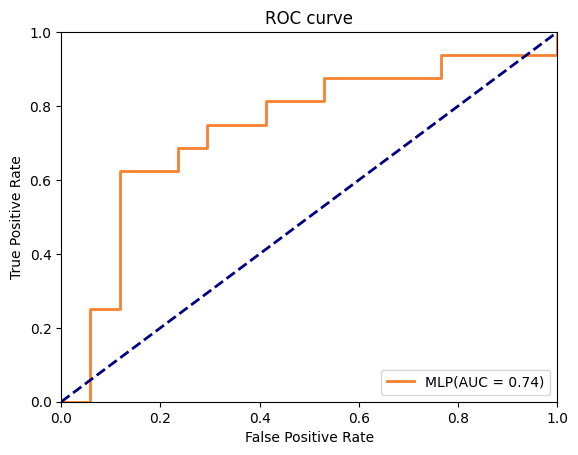

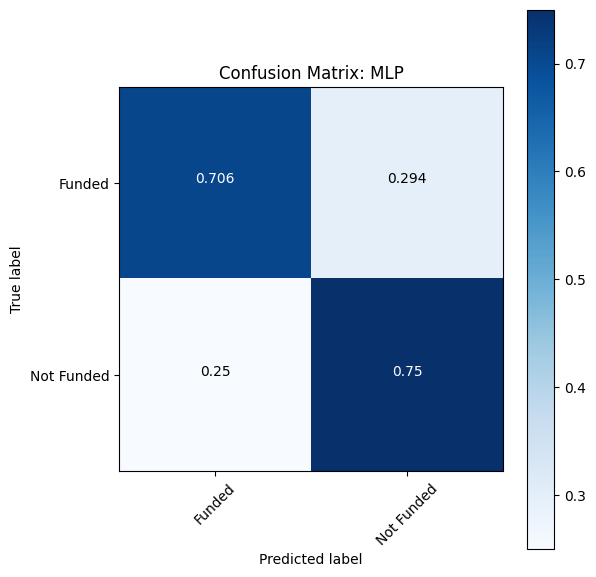

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.2, random_state=42, stratify=data_clean.iloc[:,-1])

# MLP
clf_NN = MLPClassifier(activation='relu', solver='sgd', learning_rate='adaptive', alpha=0.05, hidden_layer_sizes=(46, 11), random_state=1, max_iter=5000)
clf_NN.fit(X_train,y_train)     
predict_NN = clf_NN.predict(X_test)
predictproba_NN = clf_NN.predict_proba(X_test)[:,1]
NNAccuracy = accuracy_score(y_test,predict_NN)
print(NNAccuracy)

plotAUC(y_test,predictproba_NN,'MLP')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(y_test, predict_NN, 'MLP', normalize=True)
plt.show()